In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from darts.models import ExponentialSmoothing
from darts.models import FourTheta

import pandas as pd
from darts import TimeSeries

/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/grigorii/Library/Python/3.9/lib/python/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
df = pd.read_csv('data.csv')
df.head()


,Date,TIME,OPEN,High,LOW,Close,VOL
0,20161013,0,137.70,137.88,136.57,137.47,15111600
1,20161014,0,137.57,137.86,135.83,136.20,12920690
2,20161017,0,136.08,136.43,135.30,135.57,14793980
3,20161018,0,136.01,136.46,135.41,135.81,19026660
4,20161019,0,136.10,136.16,134.70,135.49,11799010


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1753 non-null   datetime64[ns]
 1   TIME    1753 non-null   int64         
 2   OPEN    1753 non-null   float64       
 3   High    1753 non-null   float64       
 4   LOW     1753 non-null   float64       
 5   Close   1753 non-null   float64       
 6   VOL     1753 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 96.0 KB


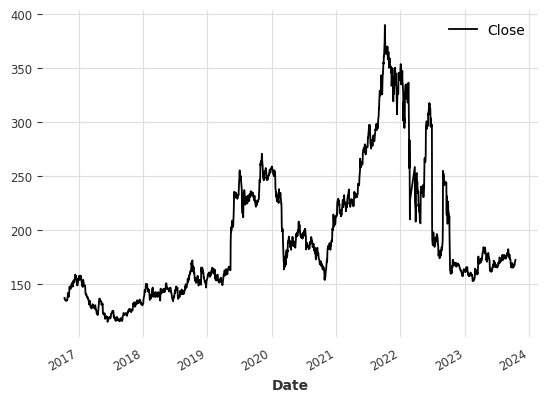

In [7]:
df.set_index('Date', inplace=True)

df.drop(df.columns.difference(['Date', 'Close']), axis=1, inplace=True)

df.plot()
plt.show()


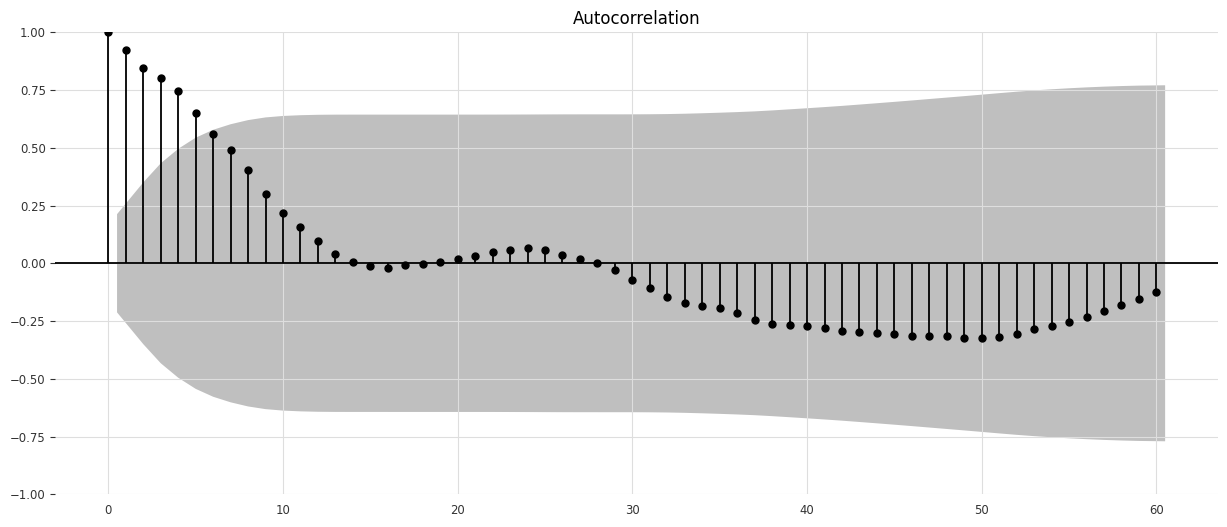

In [8]:
data = df.resample('M').mean()
_, ax = plt.subplots(figsize=(15, 6))
plot_acf(data, lags=60, ax=ax)
plt.show()

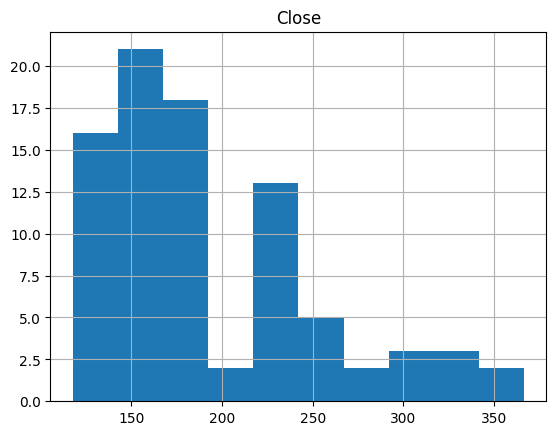

In [122]:
data.hist()
plt.show()

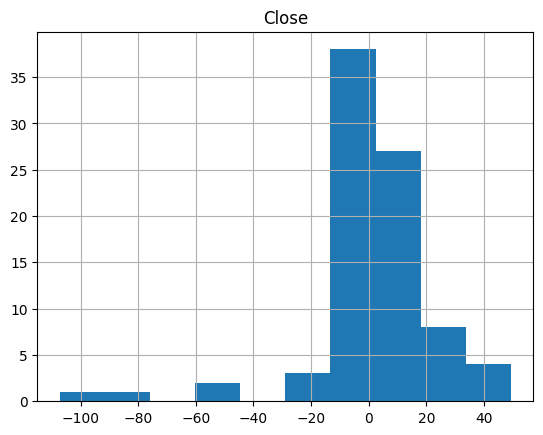

In [123]:
dataDiff = data.diff()[1:]

dataDiff.hist()
plt.show()


In [124]:
p_value = adfuller(data["Close"])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен'
)

Полученный уровень значимости (p-value): 0.2707. 0.2707 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен


In [134]:
data['Log'] = np.log(data.loc[:,'Close'])
data['LogDiff'] = data['Log'].diff()

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2017-02-28 to 2023-10-31
Freq: M
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    81 non-null     float64
 1   Log      81 non-null     float64
 2   LogDiff  81 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB


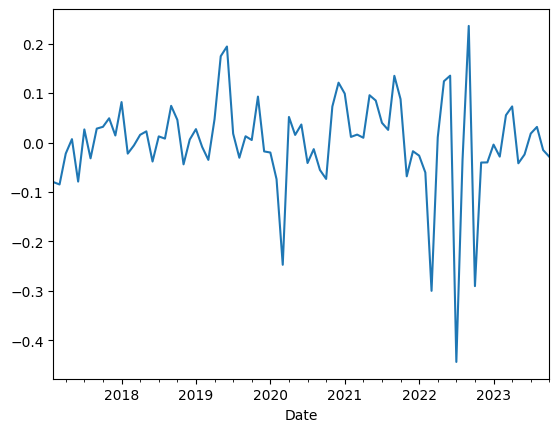

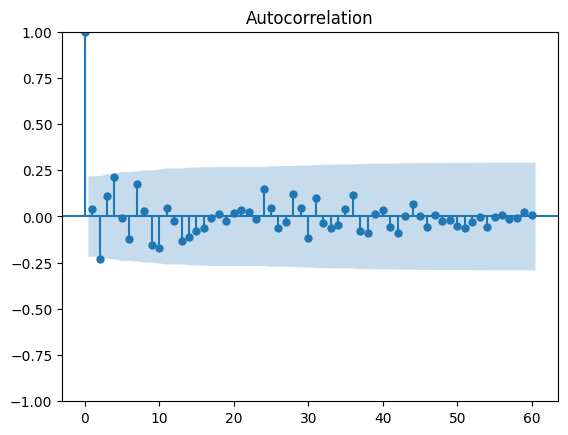

In [147]:
data['LogDiff'].plot()

plot_acf(data['LogDiff'], lags=60)
plt.show()

In [243]:
p_value = adfuller(data["LogDiff"])[1]
print(round(p_value, 4))
# Ряд стационарен. p_value < 0.05

0.0


<Axes: xlabel='Date'>

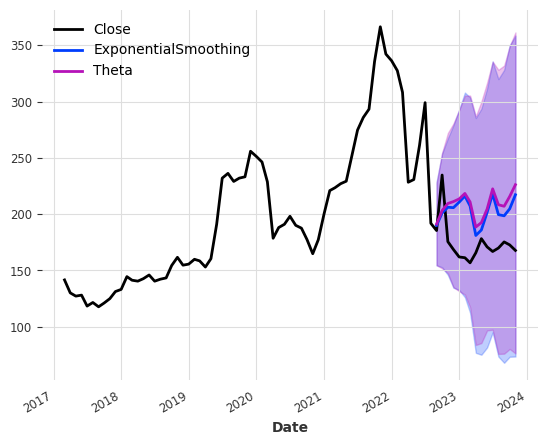

In [280]:
series = TimeSeries.from_dataframe(data, value_cols="Close")
last_size = 15
train_size = len(data) - last_size
train, val = series[:-last_size], series[-last_size:]

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

modelTheta = FourTheta(theta=2)
modelTheta.fit(train)
predictionTheta = model.predict(len(val), num_samples=1000)


series.plot()
prediction.plot(label="ExponentialSmoothing")
predictionTheta.plot(label="Theta")

<Axes: xlabel='Date'>

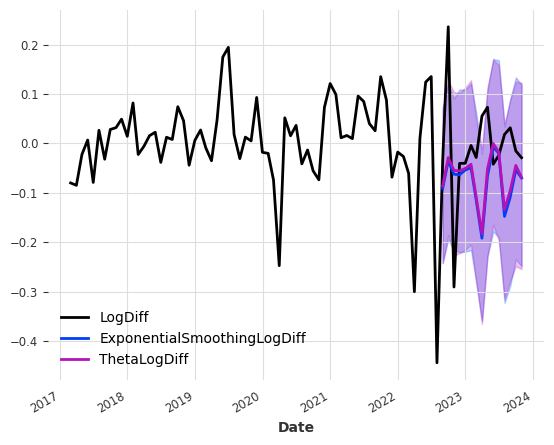

In [278]:
seriesLogDiff = TimeSeries.from_dataframe(data, value_cols="LogDiff")
trainLogDiff, valLogDiff = seriesLogDiff[:-last_size], seriesLogDiff[-last_size:]

model = ExponentialSmoothing()
model.fit(trainLogDiff)
predictionLogDiff = model.predict(len(valLogDiff), num_samples=1000)

modelTheta = FourTheta(theta=2)
modelTheta.fit(trainLogDiff)
predictionThetaLogDiff = model.predict(len(valLogDiff), num_samples=1000)


seriesLogDiff.plot()
predictionLogDiff.plot(label="ExponentialSmoothingLogDiff")
predictionThetaLogDiff.plot(label="ThetaLogDiff")


In [281]:
series.values()[train_size:]
prediction.values()

mape = mean_absolute_percentage_error(series.values()[train_size:], predictionTheta.values())

print('MAPE with real and Darts.Theta: ', mape)

MAPE with real and Darts.Theta:  0.2731350281275765


<Axes: xlabel='Date'>

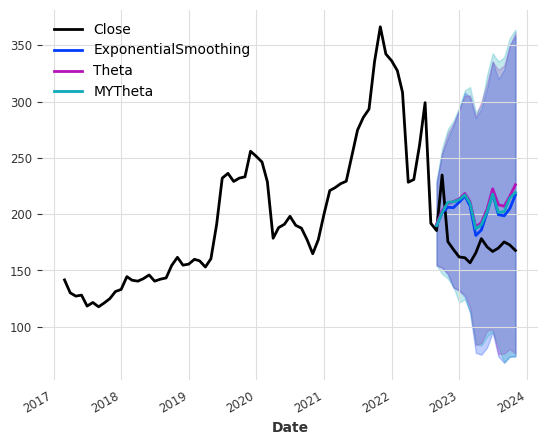

In [322]:
import statsmodels.tsa.holtwinters as hw

class MYFourTheta:
    def __init__(
        self,
        theta: int = 2,
        useLinear = True
    ):
        self.theta = theta
        self.useLinear = useLinear
        self.lmbd = 0
        if self.theta != 0:
            self.lmbd = 1 / theta

        self.un_lmbd = 1 - self.lmbd

    def fit(self, series):
        self.len = len(series)

        values = series.univariate_values()

        if self.useLinear:
            values_convert = values
        else:
            values_convert = np.log(values)
            
        self.arr = np.poly1d(np.polyfit(np.arange(self.len), values_convert, 1))
        _theta_ = self.arr(np.arange(self.len))

        _theta_1 = self.theta * values
        _theta_1 += (1 - self.theta) * _theta_

        self.model = hw.SimpleExpSmoothing(_theta_1).fit()
        _theta_2 = self.model.fittedvalues

        _theta_1 = self.theta * values
        _theta_1 += (1 - self.theta) * _theta_

        self.model = hw.SimpleExpSmoothing(_theta_1).fit()

        _theta_2 = self.model.fittedvalues
        self.fitted_values = self.lmbd * _theta_2 + self.un_lmbd * _theta_

        return self

    def predict(self, n) -> TimeSeries:
        forecast = self.model.forecast(n)

        arr = self.arr(np.arange(self.length, self.length + n))
        if not self.useLinear:
            arr = np.exp(arr)
            forecast = self.lmbd * forecast + self.un_lmbd * arr

        return self._build_forecast_series(forecast)
    

myFourTheta = MYFourTheta(theta=2)
myFourTheta.fit(train)
predictionMyTheta = model.predict(len(val), num_samples=1000)


series.plot()
prediction.plot(label="ExponentialSmoothing")
predictionTheta.plot(label="Theta")
predictionMyTheta.plot(label="MYTheta")


In [320]:
mape = mean_absolute_percentage_error(series.values()[train_size:], predictionMyTheta.values())

print('MAPE with real and MY.Theta: ', mape)

mape = mean_absolute_percentage_error(predictionTheta.values(), predictionMyTheta.values())

print('MAPE with Darts.Theta and MY.Theta: ', mape)

MAPE with real and MY.Theta:  0.18478241958733183
MAPE with Darts.Theta and MY.Theta:  0.3320866709240556


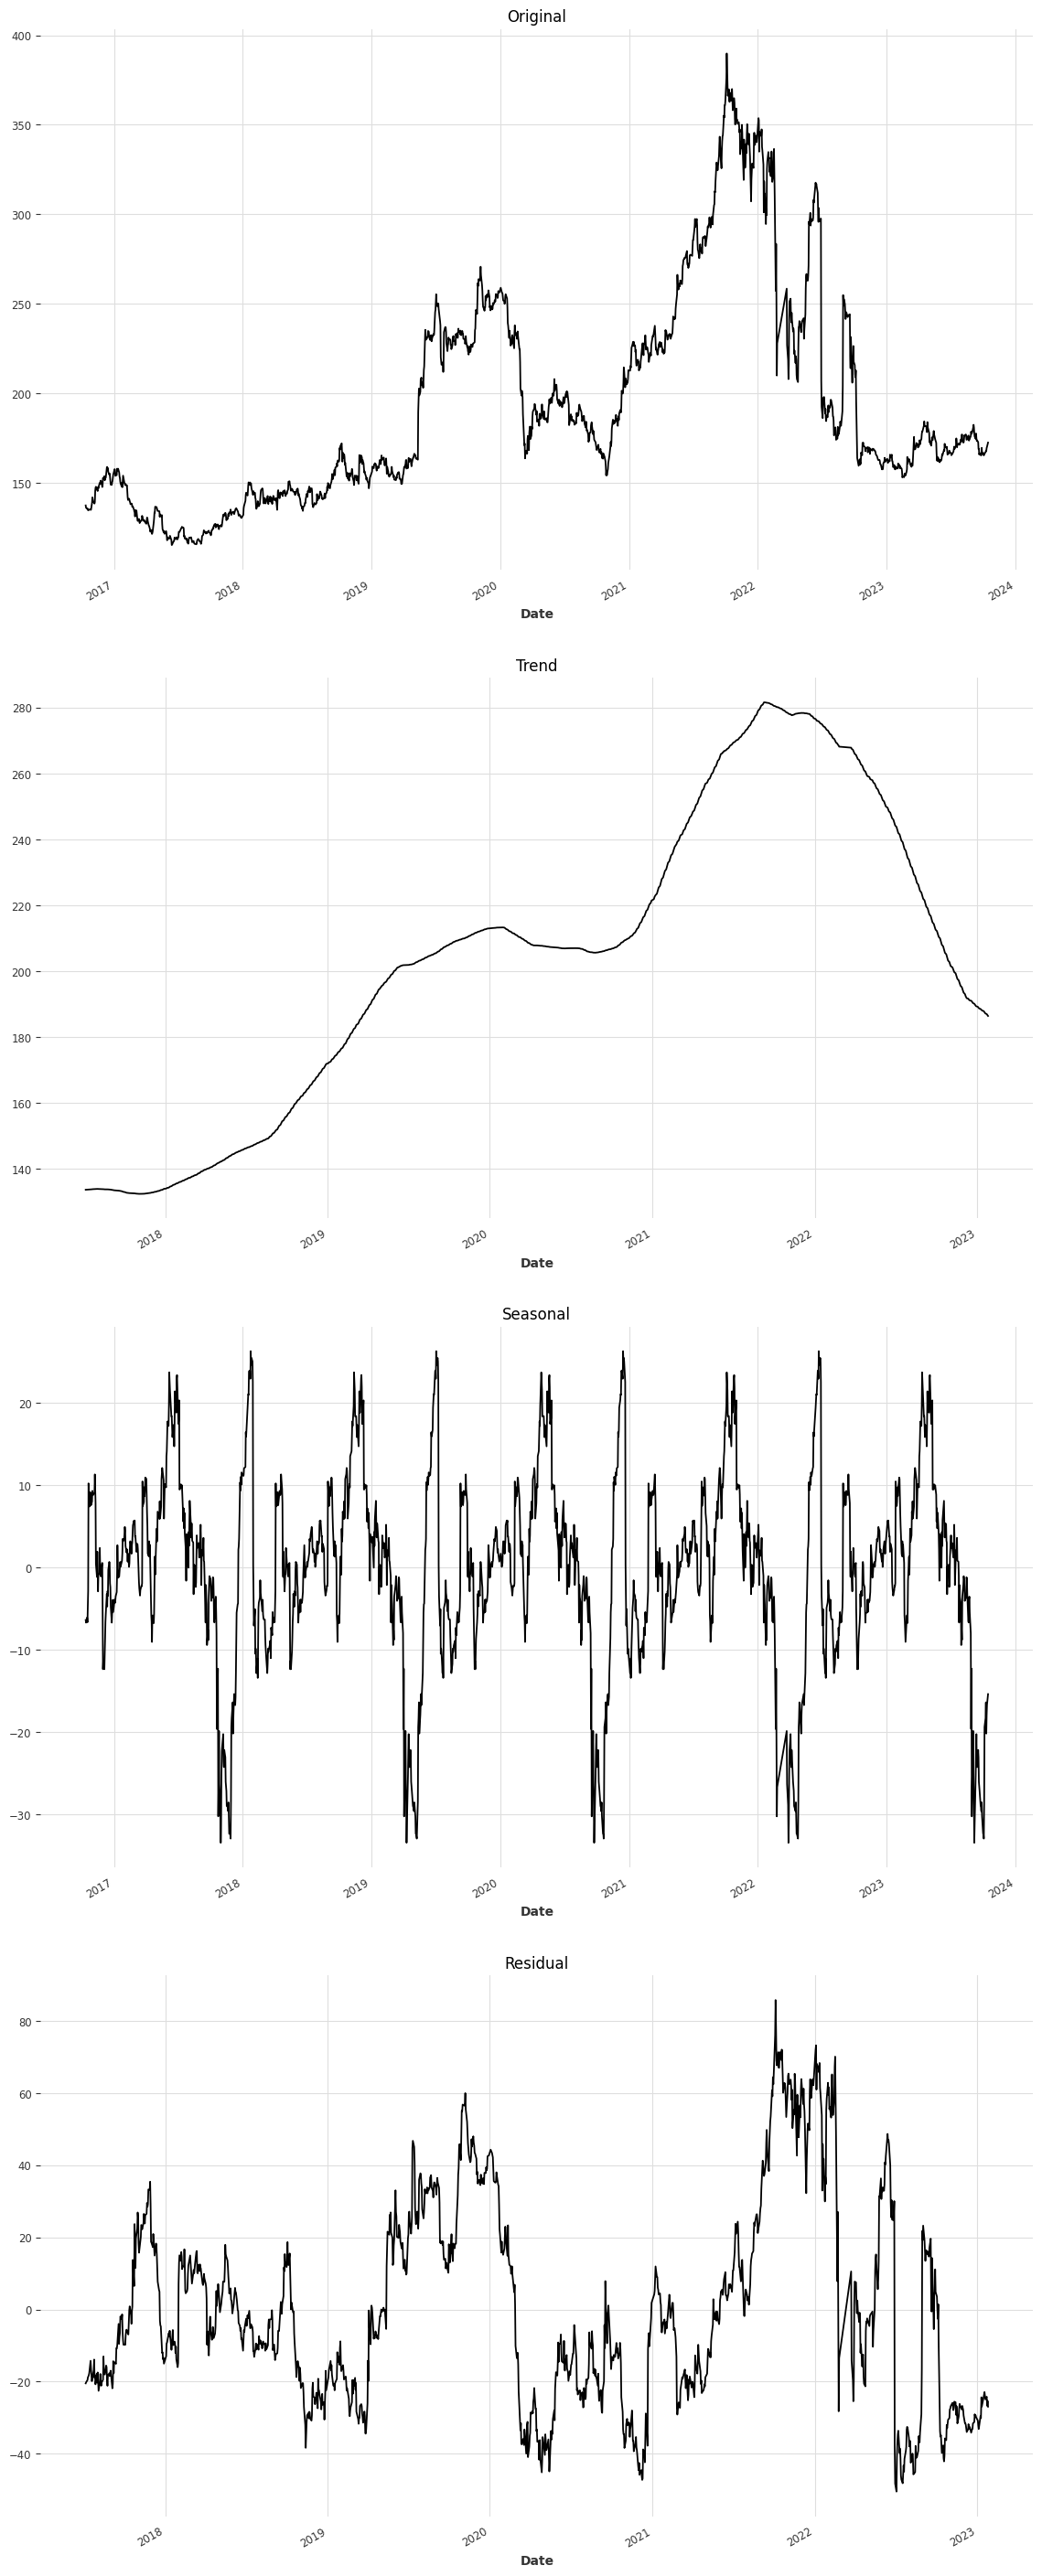

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['Close']], period=365)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);